In [1]:
import torch
import numpy as np
import pandas as pd
import requests

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline, DeepAR
from pytorch_forecasting.data import GroupNormalizer

from pytorch_forecasting.metrics import PoissonLoss, QuantileLoss, SMAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import wandb

In [2]:
URL = 'https://covid.ourworldindata.org/data/owid-covid-data.json'

In [3]:
r = requests.get(URL)
data_json = r.json()

In [4]:
df = pd.DataFrame.from_dict(data_json, 'index')

In [5]:
xs = df.drop(columns='data')
raw_ys = df.data

In [6]:
xs.shape

(191, 17)

In [7]:
import matplotlib.pyplot as plt

In [8]:
nans = xs.isnull().sum()

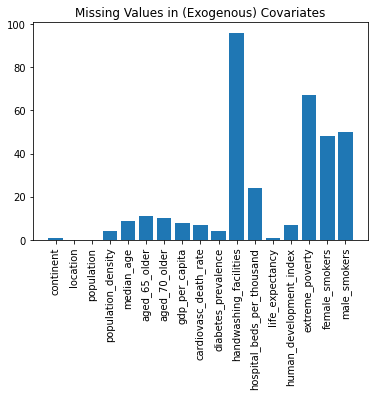

In [9]:
# look at missing values
plt.bar(nans.index.values, nans.values)
plt.title("Missing Values in (Exogenous) Covariates")
plt.xticks(rotation = 90);

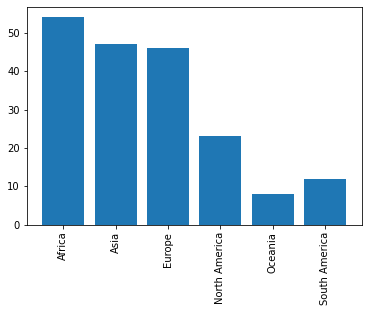

In [10]:
plt.bar(xs.groupby('continent').size().index, xs.groupby('continent').size())
plt.xticks(rotation = 90);

/home/kharuto/Documents/projects/b-kaindl/udacity_new/capstone/cov_env/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/kharuto/Documents/projects/b-kaindl/udacity_new/capstone/cov_env/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


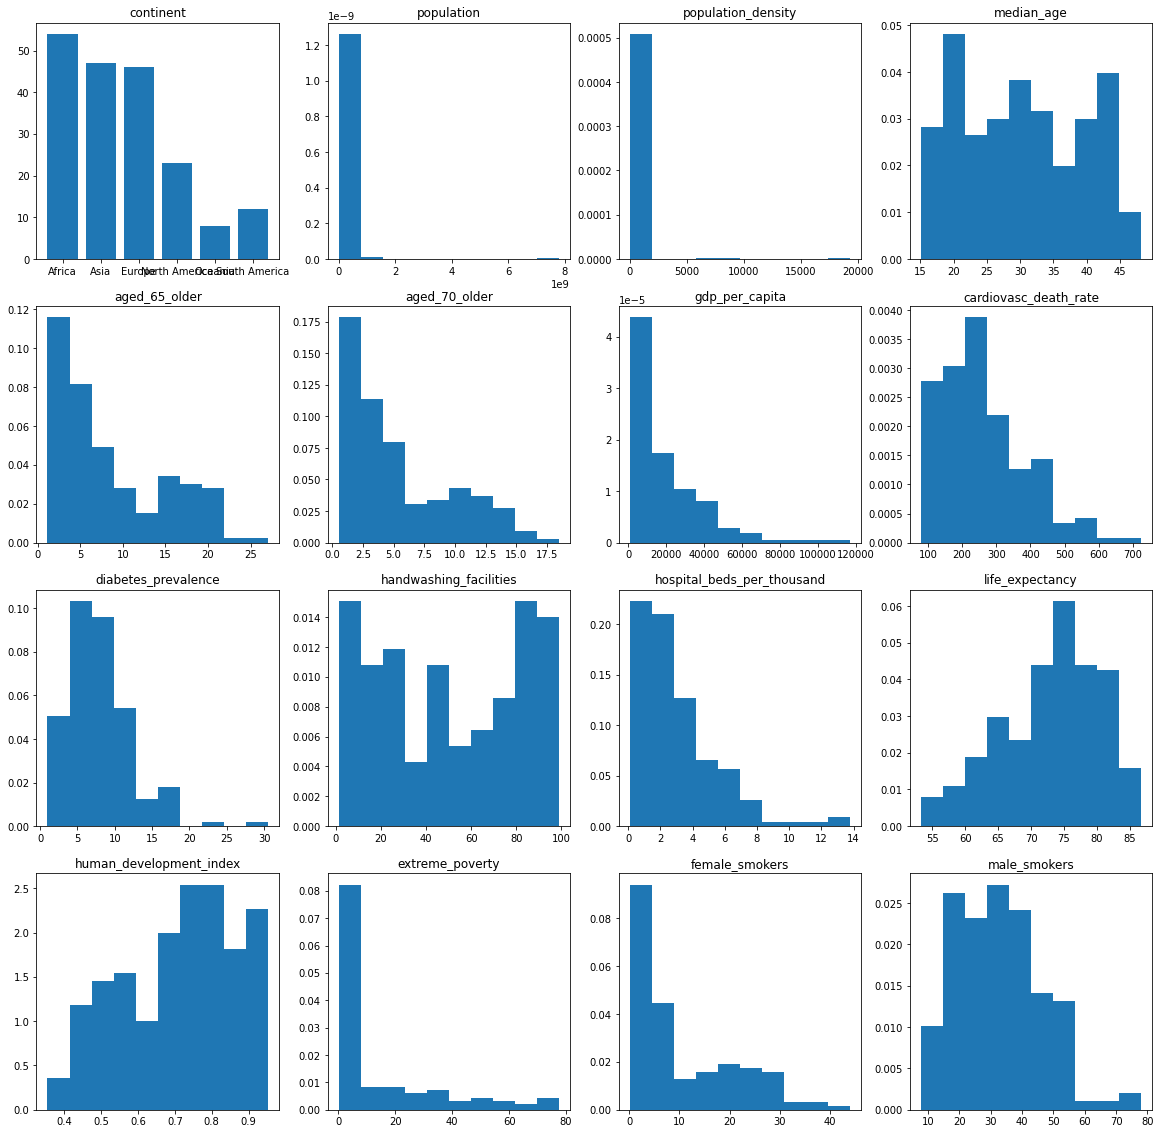

In [11]:
# plot histograms for all xs
from pandas.api.types import is_numeric_dtype

fig = plt.figure(figsize=(20,20))
# ax.set_title("Distribution of Covariates")

i = 0
for x in xs.columns:
    if(x == 'location'):
        continue
        
    i += 1
    ax = fig.add_subplot(4,4,i)
        
    if is_numeric_dtype(xs[x]):
        
        ax.set_title(x)
        ax.hist(xs[x],density=True)
    
    else:
        
        ax.bar(xs.groupby(x).size().index, xs.groupby(x).size())
        ax.set_title(x)
        
        
fig;

In [12]:
# init df with first country
ys = pd.DataFrame(raw_ys[0])
ys['location'] = raw_ys.index[0]
ys = ys.set_index('location')
ys = ys.reset_index()

# append new ones
for i in range(1,len(raw_ys)):
    new_ys = pd.DataFrame(raw_ys[i])
    new_ys['location'] = raw_ys.index[i]
    ys = ys.append(new_ys)




In [13]:
ys.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54618 entries, 0 to 332
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   location                            54618 non-null  object 
 1   date                                54618 non-null  object 
 2   total_cases                         54063 non-null  float64
 3   total_cases_per_million             54063 non-null  float64
 4   stringency_index                    48571 non-null  float64
 5   new_cases                           53874 non-null  float64
 6   new_cases_per_million               53874 non-null  float64
 7   new_cases_smoothed                  52923 non-null  float64
 8   new_deaths_smoothed                 52923 non-null  float64
 9   new_cases_smoothed_per_million      52923 non-null  float64
 10  new_deaths_smoothed_per_million     52923 non-null  float64
 11  total_deaths                        46004 n

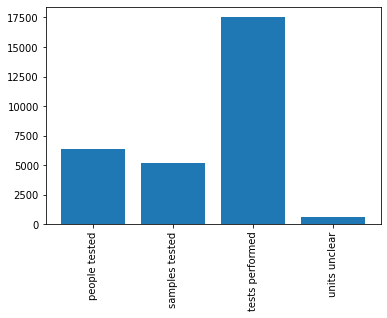

In [14]:
plt.bar(ys.groupby('tests_units').size().index, ys.groupby('tests_units').size())
plt.xticks(rotation = 90);

In [15]:
(df == 0).sum()

continent                     0
location                      0
population                    0
population_density            0
median_age                    0
aged_65_older                 0
aged_70_older                 0
gdp_per_capita                0
cardiovasc_death_rate         0
diabetes_prevalence           0
handwashing_facilities        0
hospital_beds_per_thousand    0
life_expectancy               0
human_development_index       0
data                          0
extreme_poverty               0
female_smokers                0
male_smokers                  0
dtype: int64

In [16]:
xs.columns, ys.columns

(Index(['continent', 'location', 'population', 'population_density',
        'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita',
        'cardiovasc_death_rate', 'diabetes_prevalence',
        'handwashing_facilities', 'hospital_beds_per_thousand',
        'life_expectancy', 'human_development_index', 'extreme_poverty',
        'female_smokers', 'male_smokers'],
       dtype='object'),
 Index(['location', 'date', 'total_cases', 'total_cases_per_million',
        'stringency_index', 'new_cases', 'new_cases_per_million',
        'new_cases_smoothed', 'new_deaths_smoothed',
        'new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million',
        'total_deaths', 'total_deaths_per_million', 'new_deaths',
        'new_deaths_per_million', 'reproduction_rate', 'new_tests',
        'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand',
        'tests_units', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
        'positive_rate', 'tests_per_case

In [17]:
data = ys.join(xs, on='location',rsuffix="_x").drop(columns='location_x')

In [18]:
# should have the same number of rows
data.shape, ys.shape

((54618, 51), (54618, 35))

In [19]:
# prepare data for consumption
# generously copied from https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html for testing
# compute time index in days from t0
data['date'] = pd.to_datetime(data['date'])
t_zero = data['date'].min()
data['time_idx'] = (data['date'] - t_zero).dt.days

# fill world-level continent label
data["continent"] = data["continent"].fillna('Global')

# fill nans in test units
data["tests_units"] = data["tests_units"].fillna('NA')

# TODO: see if wwe might need additional feature
data["month"] = data.date.dt.month.astype(str).astype("category")
data["continent"] = data["continent"].astype("category")
data["tests_units"] = data["tests_units"].astype("category")


In [20]:
data.sample(10)

,location,date,total_cases,total_cases_per_million,stringency_index,new_cases,new_cases_per_million,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,...,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,extreme_poverty,female_smokers,male_smokers,time_idx,month
141,SRB,2020-07-16,19717.0,2897.600,44.44,383.0,56.285,339.286,12.857,49.861,...,10.08,97.719,5.609,76.00,0.787,NaN,37.7,40.2,197,7
243,NPL,2020-09-24,69301.0,2378.469,76.85,1497.0,51.378,1389.714,10.000,47.696,...,7.26,47.782,0.300,70.78,0.574,15.0,9.5,37.8,267,9
159,SWE,2020-07-09,72082.0,7137.348,59.26,335.0,33.171,397.857,13.143,39.395,...,4.79,NaN,2.220,82.80,0.933,0.5,18.8,18.9,190,7
185,POL,2020-09-05,70387.0,1859.797,36.11,567.0,14.982,592.571,11.571,15.657,...,5.91,NaN,6.620,78.73,0.865,NaN,23.3,33.1,248,9
149,URY,2020-08-09,1353.0,389.495,26.85,18.0,5.182,9.571,0.143,2.755,...,6.93,NaN,2.800,77.91,0.804,0.1,14.0,19.9,221,8
29,CRI,2020-04-04,435.0,85.393,75.00,19.0,3.730,20.000,0.000,3.926,...,8.78,83.841,1.130,80.28,0.794,1.3,6.4,17.4,94,4
21,CIV,2020-04-01,190.0,7.203,80.56,11.0,0.417,15.714,0.000,0.596,...,2.42,19.351,NaN,57.78,0.492,28.2,NaN,NaN,91,4
248,ROU,2020-10-31,241339.0,12545.118,54.63,5753.0,299.049,5078.000,92.857,263.961,...,9.74,NaN,6.892,76.05,0.811,5.7,22.9,37.1,304,10
192,GRC,2020-09-01,10524.0,1009.685,56.02,207.0,19.860,219.571,4.000,21.066,...,4.55,NaN,4.210,82.24,0.870,1.5,35.3,52.0,244,9
282,PAN,2020-12-16,199947.0,46340.151,NaN,2960.0,686.016,2424.286,25.000,561.858,...,8.33,NaN,2.300,78.51,0.789,2.2,2.4,9.9,350,12


In [21]:
# assign new unique index 
data.index = range(0,data.shape[0])

In [22]:
run = wandb.init(project='capstone', name="cov_model_prototype")

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: kaiharuto (use `wandb login --relogin` to force relogin)


In [23]:
# set up wandb-based logging for prototype

wandb_log_prototype = WandbLogger(name="cov_model_prototype",project="capstone")

# set model parameters for wandb
config = wandb.config

# model configs for wandb

config.max_pred_length = 7 # predict at most two weeks
config.max_encoder_length = 60  # use at most 2 months as input
config.training_cutoff = data['time_idx'].max() - config.max_pred_length
config.max_epochs = 50
config.gradient_clip_val = 0.1
config.learning_rate = 0.03
config.hidden_size = 16
# number of attention heads. Set to up to 4 for large datasets
config.attention_head_size = 1
config.dropout = 0.1  # between 0.1 and 0.3 are good values
config.hidden_continuous_size = 8  # set to <= hidden_size
config.output_size = 7  # 7 quantiles by default
# reduce learning rate if no improvement in validation loss after x epochs
config.reduce_on_plateau_patience = 4
config.targets = 'new_cases'
config.static_reals = ['population','population_density','median_age','aged_65_older','aged_70_older',
                    'gdp_per_capita','cardiovasc_death_rate', 'diabetes_prevalence', 'handwashing_facilities', 
                    'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index', 'extreme_poverty', 'female_smokers','male_smokers']
config.dataset = "proto_data"
config.transformation = "softplus"
config.max_epochs=50

In [24]:


# see https://github.com/jdb78/pytorch-forecasting/issues/187#issuecomment-743797144
# simple imputation by replacing NaNs with 0
proto_data = data.fillna({name: 0.0 for name in config.static_reals})
proto_data.fillna({config.targets: 0.0}, inplace=True)


training = TimeSeriesDataSet(
    proto_data[lambda x: x.time_idx <= config.training_cutoff],
    time_idx='time_idx',
    target=config.targets,
    group_ids=['location'],
    min_encoder_length=int(config.max_encoder_length // 2),
    max_encoder_length=config.max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=config.max_pred_length,
    static_categoricals=['location', 'continent', 'tests_units'],
    static_reals = config.static_reals,
    time_varying_known_categoricals=['month'],
    time_varying_known_reals=['time_idx', 
                              #'stringency_index', 'new_tests', unknown but could be used for conditional forecasts
                             ],
    target_normalizer=GroupNormalizer(groups=['location'], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missings=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, proto_data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

/home/kharuto/Documents/projects/b-kaindl/udacity_new/capstone/cov_env/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:863: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length is too large for 1 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those seriesFirst 10 removed groups: [{'__group_id__location': 'WSM'}]
  warnings.warn(
/home/kharuto/Documents/projects/b-kaindl/udacity_new/capstone/cov_env/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:863: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length is too large for 1 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those seriesFirst 10 removed groups: [{'__group_id__location': 'WSM'}]
  warnings.warn(


In [25]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

1593.1466064453125

In [26]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    num_processes=8,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=config.gradient_clip_val,
    max_epochs=config.max_epochs,
    logger=wandb_log_prototype

)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=config.learning_rate,
    hidden_size=config.hidden_size,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=config.attention_head_size,
    dropout=config.dropout,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=config.hidden_continuous_size,  # set to <= hidden_size
    output_size=config.output_size,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=config.reduce_on_plateau_patience
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

/home/kharuto/Documents/projects/b-kaindl/udacity_new/capstone/cov_env/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: num_processes is only used for distributed_backend="ddp_cpu". Ignoring it.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 33.4k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 3.2 K 
3  | prescalers                         | ModuleDict                      | 320   
4  | static_variable_selection          | VariableSelectionNetwork        | 13.5 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

suggested learning rate: 0.02818382931264454


Finding best initial lr: 100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


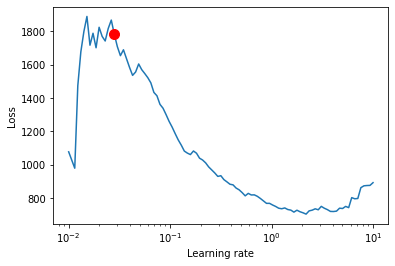

<ipython-input-27-4fb00dbde550>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [27]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-2,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [28]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 3.2 K 
3  | prescalers                         | ModuleDict                      | 320   
4  | static_variable_selection          | VariableSelectionNetwork        | 13.5 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Epoch 1: 100%|█████████▉| 427/428 [01:17<00:00,  4.25it/s, loss=363.044, v_num=651p, train_loss_step=685, train_loss_epoch=925]        
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█████████▉| 427/428 [01:32<00:00,  3.56it/s, loss=341.885, v_num=651p, train_loss_step=385, train_loss_epoch=477, val_loss=665]      
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█████████▉| 427/428 [01:36<00:00,  3.42it/s, loss=286.400, v_num=651p, train_loss_step=150, train_loss_epoch=336, val_loss=703]       
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|█████████▉| 427/428 [01:42<00:00,  3.21it/s, loss=351.090, v_num=651p, train_loss_step=99.5, train_loss_epoch=325, val_loss=707]      
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|█████████▉| 427/428 [01:34<00:00,  3.48it/s, loss=303.248, v_num=651p, train_loss_step=277, train_loss_epoch=305, val_loss=635]       
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|█████████▉| 427/428 [01:24<00:00,  3.87it/s, loss=297.432, v_num=651p, train_loss_step=237, train_lo

1

In [ ]:
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=200,
#     max_epochs=config.max_epochs,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=config.reduce_on_plateau_patience,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# # save study results - also we can resume tuning at a later point in time
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# print(study.best_trial.params)

In [31]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [32]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(1507.5232)

In [33]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

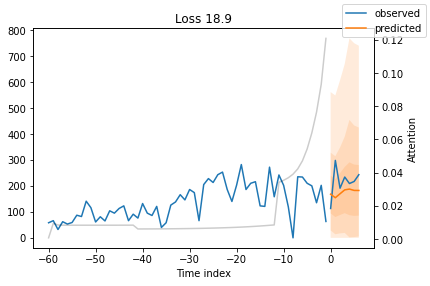

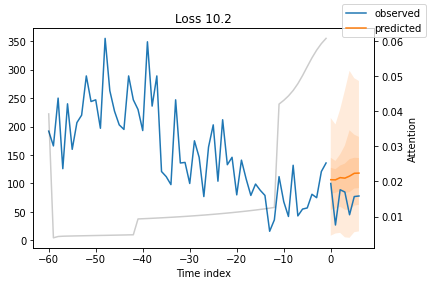

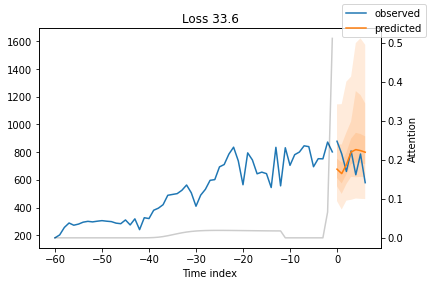

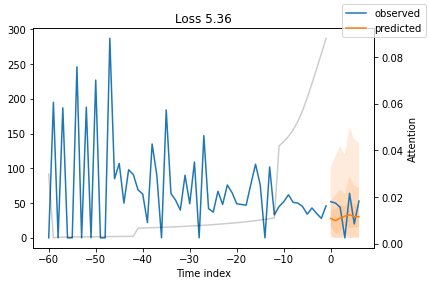

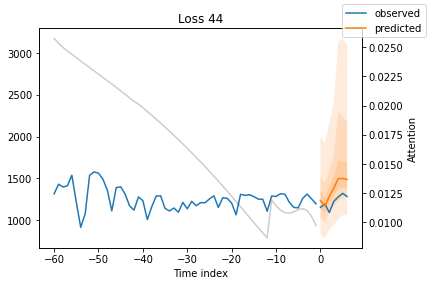

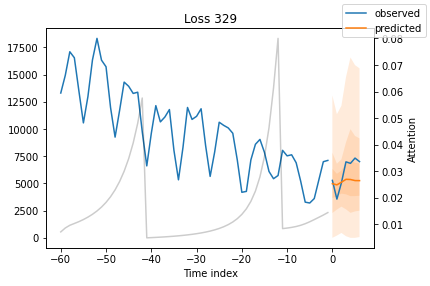

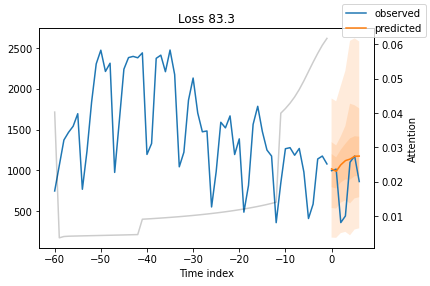

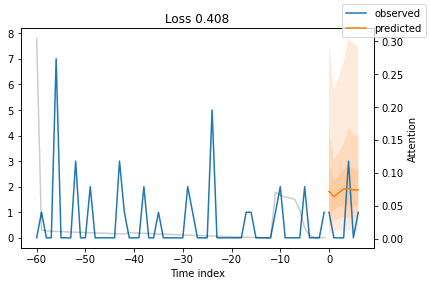

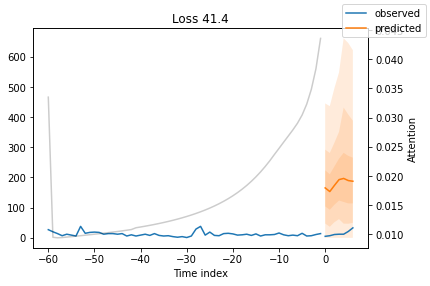

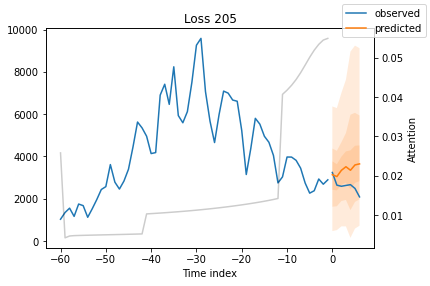

In [34]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [35]:
torch.save(best_tft.state_dict(), "20201219_tft_basemodel.pkl")

In [37]:
run.finish()

AttributeError: 'ZMQDisplayPublisher' object has no attribute '_orig_publish'

# 2nd Try - More Sophisticated Data Cleaning & Value Imputation

In [ ]:
plt.hist(data.groupby('location').nunique()['date']);

In [ ]:
plt.bar(data.groupby('date').nunique()['location'].index, data.groupby('date').nunique()['location']);

Given the high number of missing values, we might be tempted to retry model fitting without excessively sparse features (e.g. `handwashing_facilities`).
See [this article](https://www.wandb.com/articles/pytorch-lightning-with-weights-biases) to leverage wandb.

In [39]:
targets = 'new_cases'

reals = ['population','population_density','median_age','aged_65_older','aged_70_older',
                    'gdp_per_capita','cardiovasc_death_rate', 'diabetes_prevalence', 'handwashing_facilities', 
                    'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index', 'extreme_poverty', 'female_smokers','male_smokers']

In [38]:
run = wandb.init(project='capstone')

wandb: ERROR Problem finishing run
Traceback (most recent call last):
  File "/home/kharuto/Documents/projects/b-kaindl/udacity_new/capstone/cov_env/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 1215, in _atexit_cleanup
    self._on_finish()
  File "/home/kharuto/Documents/projects/b-kaindl/udacity_new/capstone/cov_env/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 1342, in _on_finish
    self.history._flush()
  File "/home/kharuto/Documents/projects/b-kaindl/udacity_new/capstone/cov_env/lib/python3.8/site-packages/wandb/sdk/wandb_history.py", line 59, in _flush
    self._callback(row=self._data, step=self._step)
  File "/home/kharuto/Documents/projects/b-kaindl/udacity_new/capstone/cov_env/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 598, in _history_callback
    self._backend.interface.publish_history(row, step)
  File "/home/kharuto/Documents/projects/b-kaindl/udacity_new/capstone/cov_env/lib/python3.8/site-packages/wandb/sdk/interface/interface.p

In [56]:
# check reals with most missing values
# remove reals with more than 50%  NaNs
clean_haze_data = data.copy()
high_missing = clean_haze_data[reals].isna().mean()[clean_haze_data[reals].isna().mean() > .5].index
print("removing: ", high_missing)
for idx in high_missing:
    reals.remove(idx)

removing:  Index([], dtype='object')


In [57]:
# set up wandb-based logging for prototype

wandb_log_ch = WandbLogger(name="clean_haze",project="capstone")

# set model parameters for wandb
config = wandb.config

# model configs for wandb

config.max_pred_length = 7 # predict at most two weeks
config.max_encoder_length = 60  # use at most 2 months as input
config.training_cutoff = data['time_idx'].max() - config.max_pred_length
config.max_epochs = 50
config.gradient_clip_val = 0.1
config.learning_rate = 0.03
config.hidden_size = 16
# number of attention heads. Set to up to 4 for large datasets
config.attention_head_size = 1
config.dropout = 0.1  # between 0.1 and 0.3 are good values
config.hidden_continuous_size = 8  # set to <= hidden_size
config.output_size = 7  # 7 quantiles by default
# reduce learning rate if no improvement in validation loss after x epochs
config.reduce_on_plateau_patience = 4
config.targets = 'new_cases'
config.static_reals = reals
config.dataset = "clean_haze"
config.transformation = "softplus"
config.max_epochs=50

In [64]:


# see https://github.com/jdb78/pytorch-forecasting/issues/187#issuecomment-743797144
# simple imputation by replacing NaNs with 0
clean_haze_data.fillna({name: 0.0 for name in config.static_reals}, inplace=True)
clean_haze_data.fillna({config.targets: 0.0}, inplace=True)


training = TimeSeriesDataSet(
    clean_haze_data[lambda x: x.time_idx <= config.training_cutoff],
    time_idx='time_idx',
    target=config.targets,
    group_ids=['location'],
    min_encoder_length=int(config.max_encoder_length // 2),
    max_encoder_length=config.max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=config.max_pred_length,
    static_categoricals=['location', 'continent', 'tests_units'],
    static_reals = config.static_reals,
    time_varying_known_categoricals=['month'],
    time_varying_known_reals=['time_idx', 
                              #'stringency_index', 'new_tests', unknown but could be used for conditional forecasts
                             ],
    target_normalizer=GroupNormalizer(groups=['location'], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missings=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, clean_haze_data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

/home/kharuto/Documents/projects/b-kaindl/udacity_new/capstone/cov_env/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:863: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length is too large for 1 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those seriesFirst 10 removed groups: [{'__group_id__location': 'WSM'}]
  warnings.warn(
/home/kharuto/Documents/projects/b-kaindl/udacity_new/capstone/cov_env/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:863: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length is too large for 1 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those seriesFirst 10 removed groups: [{'__group_id__location': 'WSM'}]
  warnings.warn(


In [65]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

1593.1466064453125

In [66]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    num_processes=8,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=config.gradient_clip_val,
    max_epochs=config.max_epochs,
    logger=wandb_log_ch

)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=config.learning_rate,
    hidden_size=config.hidden_size,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=config.attention_head_size,
    dropout=config.dropout,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=config.hidden_continuous_size,  # set to <= hidden_size
    output_size=config.output_size,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=config.reduce_on_plateau_patience
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

/home/kharuto/Documents/projects/b-kaindl/udacity_new/capstone/cov_env/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: num_processes is only used for distributed_backend="ddp_cpu". Ignoring it.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 32.7k


In [68]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-2
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

TypeError: lr_find() got an unexpected keyword argument 'logger'

In [69]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 3.2 K 
3  | prescalers                         | ModuleDict                      | 304   
4  | static_variable_selection          | VariableSelectionNetwork        | 12.8 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Epoch 1: 100%|█████████▉| 427/428 [01:38<00:00,  3.32it/s, loss=385.014, v_num=sb5s, train_loss_step=323, train_loss_epoch=905]        
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█████████▉| 427/428 [01:46<00:00,  3.08it/s, loss=347.840, v_num=sb5s, train_loss_step=574, train_loss_epoch=469, val_loss=746]      
Validating: 0it [00:00, ?it/s]
Epoch 3:  38%|███▊      | 163/428 [00:40<02:45,  1.60it/s, loss=307.576, v_num=sb5s, train_loss_step=211, train_loss_epoch=390, val_loss=864]      

Exception ignored in: <function tqdm.__del__ at 0x7fa044469790>
Traceback (most recent call last):
  File "/home/kharuto/Documents/projects/b-kaindl/udacity_new/capstone/cov_env/lib/python3.8/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/home/kharuto/Documents/projects/b-kaindl/udacity_new/capstone/cov_env/lib/python3.8/site-packages/tqdm/std.py", line 1325, in close
    fp_write('')
  File "/home/kharuto/Documents/projects/b-kaindl/udacity_new/capstone/cov_env/lib/python3.8/site-packages/tqdm/std.py", line 1322, in fp_write
    self.fp.write(_unicode(s))
  File "/home/kharuto/Documents/projects/b-kaindl/udacity_new/capstone/cov_env/lib/python3.8/site-packages/tqdm/utils.py", line 143, in inner
    return func(*args, **kwargs)
  File "/home/kharuto/Documents/projects/b-kaindl/udacity_new/capstone/cov_env/lib/python3.8/site-packages/wandb/sdk/lib/redirect.py", line 91, in new_write
    cb(name, data)
  File "/home/kharuto/Documents/projects/b-kaindl/udacity

Epoch 3: 100%|█████████▉| 427/428 [02:17<00:00,  2.39it/s, loss=441.888, v_num=sb5s, train_loss_step=238, train_loss_epoch=390, val_loss=864]    
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|█████████▉| 427/428 [01:42<00:00,  3.21it/s, loss=390.268, v_num=sb5s, train_loss_step=249, train_loss_epoch=392, val_loss=722]       
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|█████████▉| 427/428 [01:44<00:00,  3.14it/s, loss=493.808, v_num=sb5s, train_loss_step=150, train_loss_epoch=359, val_loss=690]       
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|█████████▉| 427/428 [01:45<00:00,  3.11it/s, loss=408.692, v_num=sb5s, train_loss_step=278, train_loss_epoch=354, val_loss=740]      
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|█████████▉| 427/428 [01:47<00:00,  3.05it/s, loss=318.218, v_num=sb5s, train_loss_step=160, train_loss_epoch=386, val_loss=785]       
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|█████████▉| 427/428 [01:45<00:00,  3.11it/s, loss=404.364, v_num=sb5s, train_loss_step=620

1

In [ ]:
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=200,
#     max_epochs=config.max_epochs,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=config.reduce_on_plateau_patience,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# # save study results - also we can resume tuning at a later point in time
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# print(study.best_trial.params)

In [31]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [32]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(1507.5232)

In [33]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

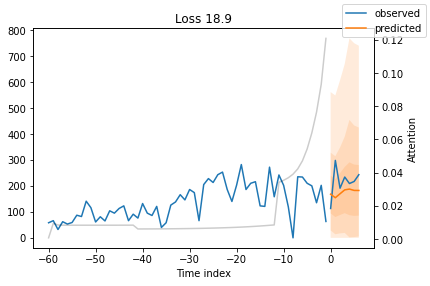

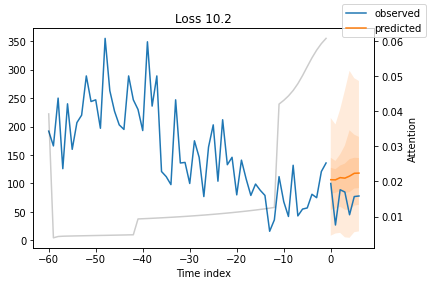

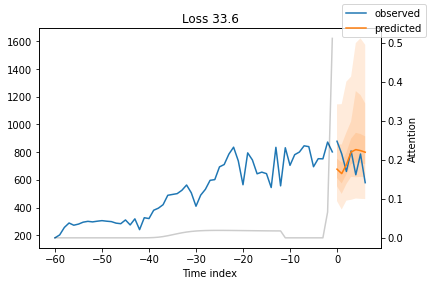

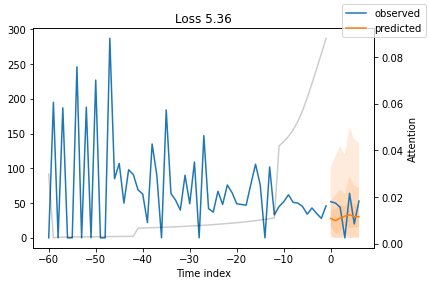

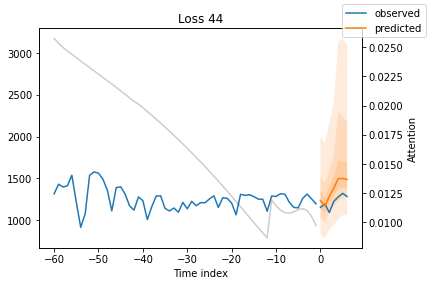

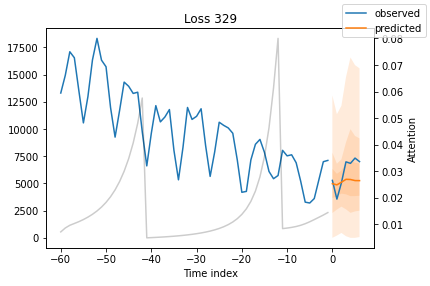

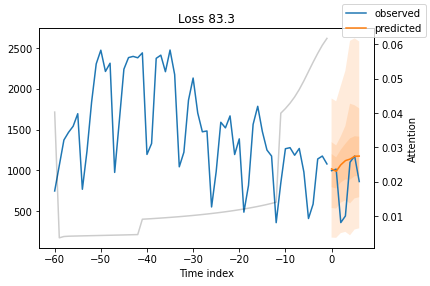

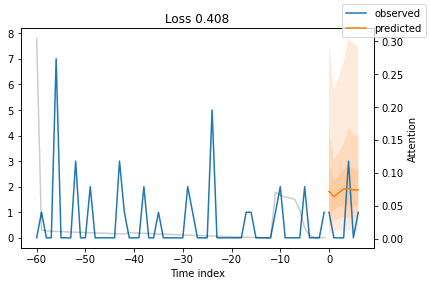

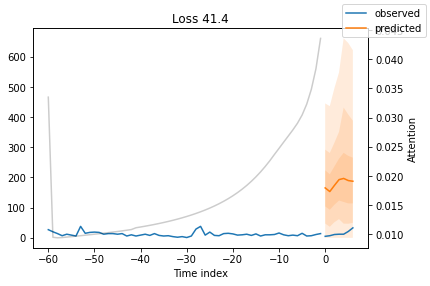

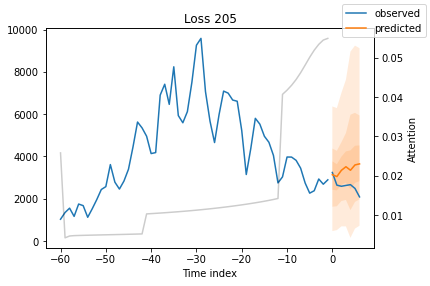

In [34]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);